# Section 1: ANN vs. Classical Models for CIFAR-10

## Loading Data

The data will be loaded and preprocessed based on pipelines from the previous project.

In [1]:
# Import custom scikit-learn transformers
from Pipelines.custom_transformers import *

In [2]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
import joblib

# Load preprocessing pipeline
preprocessing = joblib.load('Pipelines/preprocessing.pkl')
preprocessing

Pipeline(steps=[('dataset_combiner', DatasetCombiner()),
                ('reshaper', Reshaper()), ('splitter', Splitter()),
                ('scaler', Scaler())])

In [4]:
# Apply preprocessing pipeline
X_train, X_test, y_train, y_test = preprocessing.fit_transform((X_train, X_test, y_train, y_test))

## Building ANN and Tuning

We will first build the architecture of the ANN model, allowing for flexibility in terms of the activation function and number of neurons in each layer.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import HyperModel
from tensorflow.keras.callbacks import EarlyStopping

class HyperANN(HyperModel):

    def __init__(self, *args, epochs=5, num_features=3072, **kwargs):
        super().__init__(*args, **kwargs)
        self.epochs = epochs
        self.num_features = num_features

    def build(self, hp):

        # Hyperparameters
        num_neurons = [16, 32, 64, 128, 256, 512]
        activations = ['relu', 'selu', 'leaky_relu']
        dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
        num_hidden = [2, 3, 4, 5, 6]
        optimizers = ['adam', 'sgd']
        learning_rates = [1e-5, 1e-4, 1e-3]

        # Input layer (dense with dropout)
        model = Sequential()
        activation = hp.Choice('input_activation', activations)

        if activation == 'selu':
            initializer='lecun_normal'
        else:
            initializer='he_normal'

        model.add(Input(shape=(self.num_features,)))
        model.add(Dense(hp.Choice('input_neurons', num_neurons), activation=activation, kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Choice('input_dropout', dropouts)))

        # Dense hidden layers
        num_hidden_layers = hp.Choice('num_hidden_layers', num_hidden)
        
        for i in range(num_hidden_layers):

            activation = hp.Choice(f'hidden_activation{i}', activations)
        
            if activation == 'selu':
                initializer='lecun_normal'
            else:
                initializer='he_normal'

            model.add(Dense(hp.Choice(f'hidden_neurons{i}', num_neurons), activation=activation, kernel_initializer=initializer))
            model.add(BatchNormalization())
            model.add(Dropout(hp.Choice(f'hidden_dropout{i}', dropouts)))

        # Dense output layer
        model.add(Dense(10, activation='softmax'))

        # Determine batch size for the future fitting
        batch_size=hp.Choice('batch_size', [16, 32, 64, 128, 256])
        self.batch_size = batch_size

        # Compiling model
        learning_rate = hp.Choice('learning_rate', learning_rates)
        optimizer = hp.Choice('optimizer', optimizers)
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
        else:
            raise NameError('Optimizer name has not been dealt with properly!')
        
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):

        early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
)

        return model.fit(
            *args,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping]
            **kwargs,
        )

Now, we can tune the ANN using 10 epochs and early stopping with a patience of 5.

In [6]:
from keras_tuner import RandomSearch
import time

# Tune and track time
tuner = RandomSearch(HyperANN(epochs=10, num_features=X_train.shape[1]).build, objective='val_accuracy', max_trials=200, directory='ANN_Results')

start_time = time.time()
tuner.search(X_train, y_train, validation_split=0.2)
end_time = time.time()

tuning_time_secs = end_time-start_time
tuning_time_mins = tuning_time_secs/60
print('------------------------------------------------------------------')
print(f'Time to Tune: {tuning_time_mins} mins')
print('------------------------------------------------------------------')

Trial 200 Complete [00h 00m 09s]
val_accuracy: 0.17114582657814026

Best val_accuracy So Far: 0.40666666626930237
Total elapsed time: 00h 25m 51s
------------------------------------------------------------------
Time to Tune: 25.85037029981613 mins
------------------------------------------------------------------


The ANN will be trained with more epochs.

In [7]:
# Get best tuned model
best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_params = best_trial.hyperparameters.values

# Show best parameters
print('------------------------------------------------------------------')
print(f'Best Parameters: {best_params}')
print('------------------------------------------------------------------')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train with more epochs
start_time = time.time()
best_model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=best_params['batch_size'], callbacks=[early_stopping])
end_time = time.time()

# Show time to train with more epochs
tuning_time_secs = end_time-start_time
tuning_time_mins = tuning_time_secs/60
print('------------------------------------------------------------------')
print(f'Time to Train with More Epochs: {tuning_time_mins} mins')
print('------------------------------------------------------------------')

# Save model
best_model.save('Models/ANN.keras')

c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


------------------------------------------------------------------
Best Parameters: {'input_activation': 'leaky_relu', 'input_neurons': 512, 'input_dropout': 0.0, 'num_hidden_layers': 2, 'hidden_activation0': 'leaky_relu', 'hidden_neurons0': 512, 'hidden_dropout0': 0.2, 'hidden_activation1': 'leaky_relu', 'hidden_neurons1': 64, 'hidden_dropout1': 0.3, 'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam', 'hidden_activation2': 'selu', 'hidden_neurons2': 16, 'hidden_dropout2': 0.2, 'hidden_activation3': 'relu', 'hidden_neurons3': 256, 'hidden_dropout3': 0.5, 'hidden_activation4': 'relu', 'hidden_neurons4': 128, 'hidden_dropout4': 0.1, 'hidden_activation5': 'selu', 'hidden_neurons5': 512, 'hidden_dropout5': 0.5}
------------------------------------------------------------------
Epoch 1/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3288 - loss: 1.9484 - val_accuracy: 0.4349 - val_loss: 1.6076
Epoch 2/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.36

Note that if the number of hidden layers chosen is 2 for example, in the chosen hyperparameters you might see parameters like "hidden_neurons3" which would be the number of hidden neurons in the 4th layer (index 3). This seems contradictory but it is because the tuning would assign values to old parameters even if they were not needed for the current trial. Regardless, the "num_hidden_layers" parameter indicates how many layers were chosen and the extra parameters can be ignored. Next, we will show loss and validation across the epochs.

Validation Accuracy: 0.5282291769981384
Training Accuracy: 0.5778385400772095


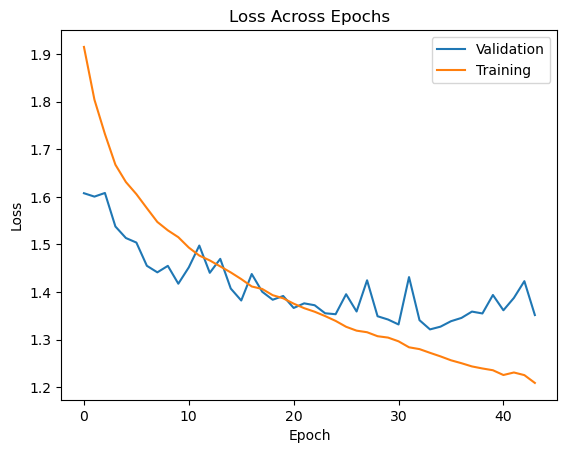

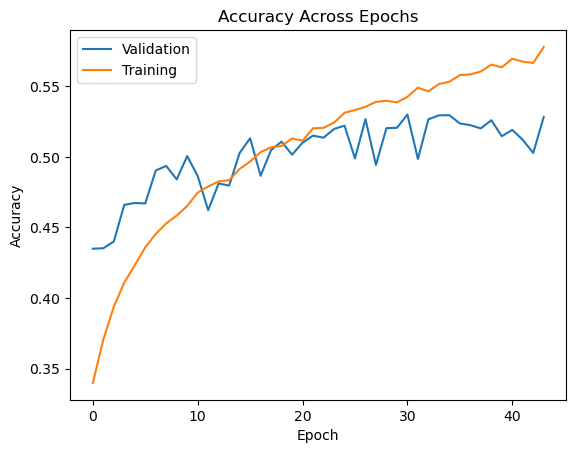

In [8]:
import matplotlib.pyplot as plt

# Print accuracy of saved state
print(f"Validation Accuracy: {best_model.history.history['val_accuracy'][-1]}")
print(f"Training Accuracy: {best_model.history.history['accuracy'][-1]}")

# Plot loss
val_loss = best_model.history.history['val_loss']
plt.plot(range(len(val_loss)), val_loss, label='Validation')
train_loss = best_model.history.history['loss']
plt.plot(range(len(train_loss)), train_loss, label='Training')
plt.title('Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy
val_accuracy = best_model.history.history['val_accuracy']
plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
train_accuracy = best_model.history.history['accuracy']
plt.plot(range(len(train_accuracy)), train_accuracy, label='Training')
plt.title('Accuracy Across Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Compare to Classical Models

The previously found best classical model with dimensionality reduction and the best classical model without dimensionality reduction will be compared to the ANN on the training set.

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, X_true, y_true, is_ANN=False):

    """ Evaluate Model Performance """

    # List class names in order
    class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"]

    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_true)
    if is_ANN:
        y_pred = np.argmax(y_pred, axis=-1)
    end_time = time.time()
    
    # Show prediction time
    pred_time_secs = end_time - start_time
    print(f'Time Taken to Make Prediction: {pred_time_secs} secs')
    print()

    # Precision, Recall, F1-score
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [10]:
import zipfile
import os

# Extract models from zip if it's not already unzipped
if not os.path.exists('Models'):

    file_path = 'Models.zip'

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall()

Now we can evaluate the models on the training set ...

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Time Taken to Make Prediction: 2.4192731380462646 secs

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      4800
           1       0.72      0.75      0.73      4800
           2       0.56      0.39      0.46      4800
           3       0.51      0.34      0.41      4800
           4       0.48      0.63      0.55      4800
           5       0.55      0.50      0.52      4800
           6       0.58      0.77      0.66      4800
           7       0.78      0.61      0.69      4800
           8       0.71      0.75      0.73      4800
           9       0.68      0.70      0.69      4800

    accuracy                           0.61     48000
   macro avg       0.62      0.61      0.61     48000
weighted avg       0.62      0.61      0.61     48000


Confusion Matrix


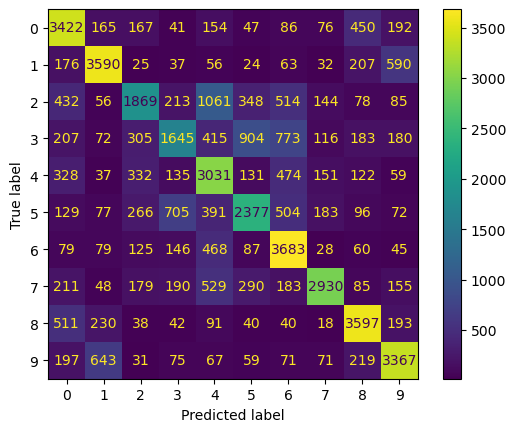

In [11]:
# Evaluate ANN
ann_model = best_model
evaluate(ann_model, X_train, y_train, is_ANN=True)

Time Taken to Make Prediction: 5.8763439655303955 secs

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4800
           1       1.00      1.00      1.00      4800
           2       1.00      1.00      1.00      4800
           3       1.00      1.00      1.00      4800
           4       1.00      1.00      1.00      4800
           5       1.00      1.00      1.00      4800
           6       1.00      1.00      1.00      4800
           7       1.00      1.00      1.00      4800
           8       1.00      1.00      1.00      4800
           9       1.00      1.00      1.00      4800

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000


Confusion Matrix


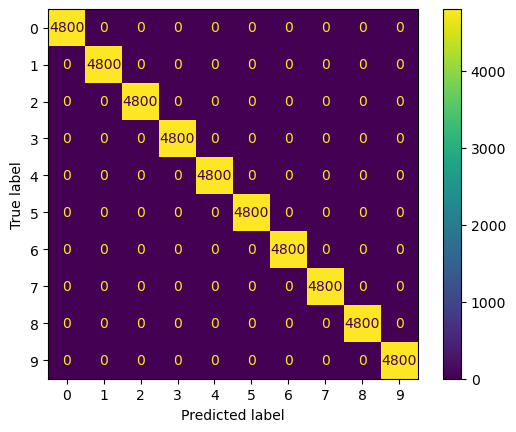

In [12]:
import joblib

# Evaluate best classical model without dimensionality reduction (random forest)
rf_raw = joblib.load('Models/random_forest_raw.pkl')
evaluate(rf_raw, X_train, y_train, is_ANN=False)

Time Taken to Make Prediction: 3.1078684329986572 secs

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4800
           1       1.00      1.00      1.00      4800
           2       1.00      1.00      1.00      4800
           3       1.00      1.00      1.00      4800
           4       1.00      1.00      1.00      4800
           5       1.00      1.00      1.00      4800
           6       1.00      1.00      1.00      4800
           7       1.00      1.00      1.00      4800
           8       1.00      1.00      1.00      4800
           9       1.00      1.00      1.00      4800

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000


Confusion Matrix


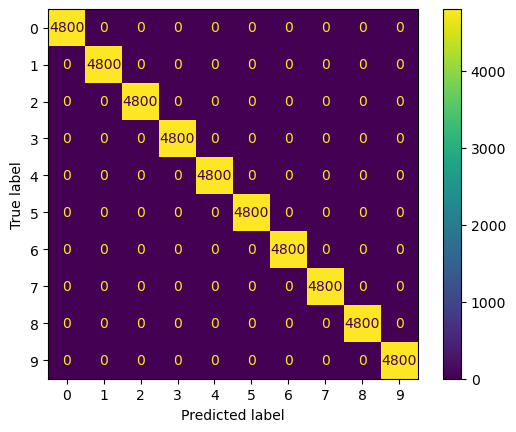

In [13]:
# Evaluate best classical model with dimensionality reduction (random forest PCA)
rf_pca = joblib.load('Models/random_forest_pca.pkl')
evaluate(rf_pca, X_train, y_train, is_ANN=False)

## Gradio UI

Gradio will be used so that users can upload their own images and get a classification from the ANN.

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load trained ANN
ANN_model = load_model('Models/ANN.keras')

# Function called during gradio interaction (preprocesses image and makes prediction)
def predict(img):

    try:
        # Resize image to 32x32
        new_size = (32, 32)
        img = img['composite'][:, :, :3]
        img = image.smart_resize(img, new_size)

        # Flatten
        img = np.array(img).flatten()

        # Scale
        img = img/255
        sample = np.array([img])

        # Make prediction
        prediction = ANN_model.predict(sample)
        prediction = np.argmax(prediction, axis=-1)[0]

        # Map prediction to its corresponding name
        class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                    "dog", "frog", "horse", "ship", "truck"]
        prediction = class_names[prediction]

    except Exception as e:
        return ''

    return prediction

# Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.ImageEditor(label='Upload or Draw an Image', type='numpy'),
    outputs=gr.Text(label='Prediction'),
    title='Image Classification',
    description='Upload an image to classify it as one of the following: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck**.',
    live=True
)

# Launch app
interface.launch()

* Running on local URL:  http://127.0.0.1:7884

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\gradio\blocks.py", line 2132, in process_api
    inputs = await self.preprocess_data(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\gradio\blocks.py", line 1813, in preprocess_data
    processed_input.append(block.preprocess(inputs_cached))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\envs\ML_env\Lib\site-packages\gradio\components\image_editor.py", line 419, in pre

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
